In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time
import random 
import pandas as pd
import torch
from torch import nn, cuda, optim
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader,random_split
from PIL import Image
import seaborn as sns
import torch.nn.functional as F

device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
%cd /content/gdrive/MyDrive/competition
!mkdir ./dataset
!unzip /content/gdrive/MyDrive/Bird.zip -d ./dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/Bird/train/TASMANIAN HEN/108.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/109.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/110.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/111.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/112.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/113.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/114.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/115.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/116.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/117.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/118.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/119.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/120.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/121.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/122.jpg  
  inflating: ./dataset/Bird/train/TASMANIAN HEN/123.jpg  
  inflating: ./dataset/Bird/train/TA

In [5]:
data_dir = '/content/gdrive/MyDrive/competition/dataset/Bird/train'

classes = []
img_per_class = []
# for folder in os.listdir(data_dir+'consolidated'):/
for folder in os.listdir(data_dir):    
    classes.append(folder)
    img_per_class.append(len(os.listdir(f'{data_dir}/{folder}')))
num_classes = len(classes)
df = pd.DataFrame({'Classes':classes, 'Examples':img_per_class})
df

,Classes,Examples
0,ABBOTTS BABBLER,166
1,ABBOTTS BOOBY,180
2,ABYSSINIAN GROUND HORNBILL,179
3,AFRICAN CROWNED CRANE,137
4,AFRICAN EMERALD CUCKOO,146
...,...,...
395,WILSONS BIRD OF PARADISE,126
396,WOOD DUCK,214
397,YELLOW BELLIED FLOWERPECKER,129
398,YELLOW CACIQUE,155


In [6]:
%cd /content/gdrive/MyDrive/sam-main/example

/content/gdrive/MyDrive/sam-main/example


In [7]:
import argparse
import torch

from model.wide_res_net import WideResNet
from model.smooth_cross_entropy import smooth_crossentropy
from utility.log import Log
from utility.initialize import initialize
from utility.step_lr import StepLR
from utility.bypass_bn import enable_running_stats, disable_running_stats

import sys; sys.path.append("..")
from sam import SAM

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--adaptive", default=True, type=bool, help="True if you want to use the Adaptive SAM.")
parser.add_argument("--batch_size", default=32, type=int, help="Batch size used in the training and validation loop.")
parser.add_argument("--depth", default=10, type=int, help="Number of layers.")
parser.add_argument("--dropout", default=0.0, type=float, help="Dropout rate.")
parser.add_argument("--epochs", default=50, type=int, help="Total number of epochs.")
parser.add_argument("--label_smoothing", default=0.1, type=float, help="Use 0.0 for no label smoothing.")
parser.add_argument("--learning_rate", default=0.1, type=float, help="Base learning rate at the start of the training.")
parser.add_argument("--momentum", default=0.9, type=float, help="SGD Momentum.")
parser.add_argument("--threads", default=2, type=int, help="Number of CPU threads for dataloaders.")
parser.add_argument("--rho", default=2.0, type=int, help="Rho parameter for SAM.")
parser.add_argument("--weight_decay", default=0.0005, type=float, help="L2 weight decay.")
parser.add_argument("--width_factor", default=5, type=int, help="How many times wider compared to normal ResNet.")
args = parser.parse_args("")

initialize(args, seed=42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = WideResNet(args.depth, args.width_factor, args.dropout, in_channels=3, labels=400).to(device)
log = Log(log_each=10)


base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=args.rho, adaptive=args.adaptive, lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay)
scheduler = StepLR(optimizer, args.learning_rate, args.epochs)

In [16]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 5000000:
    print('Your model has the number of parameters more than 5 millions..')
    sys.exit()
    
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
model.to(device)
print(device)

Number of parameters: 4414944
cuda:0


In [17]:
train_transform = transforms.Compose([transforms.Resize((32,32)), transforms.RandomRotation(45),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize((32,32)), transforms.RandomRotation(45),transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [18]:
data = datasets.ImageFolder(data_dir)
train_size = int(len(data)*0.9)
val_size = int((len(data)-train_size))
train_data,val_data = random_split(data,[train_size,val_size])
torch.manual_seed(3334)
print(f'train size: {len(train_data)}\nval size: {len(val_data)}')

train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform
batch_size = 32
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=False)

train size: 52549
val size: 5839


In [19]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [20]:
def fit(model,criterion,optimizer,num_epochs=10):
    print_freq = 100
    start = time.time()
    best_model = model.state_dict()
    best_acc = 0
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []


    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        
        print("\n----- epoch: {}, lr: {} -----".format(epoch, optimizer.param_groups[0]["lr"]))
        batch_time = AverageMeter('Time', ':6.3f')
        acc = AverageMeter('Accuracy', ':.4e')
        progress = ProgressMeter(len(train_loader), batch_time, acc, prefix="Epoch: [{}]".format(epoch))

        for phase in ['train','val']:
            
            if phase == 'train':
                data_loader = train_loader
                model.train()                    # set the model to train mode
                end = time.time()

            else:
                data_loader = val_loader
                model.eval()                    # set the model to evaluate mode
                end = time.time()
            
                
            running_loss = 0.0
            running_corrects = 0.0
            
            # iterate over the data
            for i,(inputs,labels) in enumerate(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    enable_running_stats(model)
                    outputs = model(inputs)
                    _,pred = torch.max(outputs,dim=1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.first_step(zero_grad=True)
                        disable_running_stats(model)
                        smooth_crossentropy(model(inputs), labels, smoothing=args.label_smoothing).mean().backward()
                        optimizer.second_step(zero_grad=True)
                        with torch.no_grad():
                            scheduler(epoch)
                
                # calculating the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

                epoch_acc = (running_corrects.double()/len(train_data)).cpu().numpy()
                acc.update(epoch_acc.item(), inputs.size(0))
                
                if phase == 'train':                          
                    batch_time.update(time.time() - end)
                    end = time.time()

                    if i % print_freq == 0:
                        progress.print(i)  

            if phase == 'train':

                epoch_loss = running_loss/len(train_data)
                train_loss_over_time.append(epoch_loss)
                epoch_acc = (running_corrects.double()/len(train_data)).cpu().numpy()
                train_acc_over_time.append(epoch_acc)


            else:
                epoch_loss = running_loss/len(val_data)
                val_loss_over_time.append(epoch_loss)
                epoch_acc = (running_corrects.double()/len(val_data)).cpu().numpy()
                val_acc_over_time.append(epoch_acc)
          

            print(f'{phase} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'model_best.pt')
            
            torch.save(model.state_dict(),'model_latest.pt')
            

        print('-'*60)
    print('\n') 
    elapsed_time = time.time() - start
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    print(f'best accuracy: {best_acc:.3f}')


    # load best model weights
    model.load_state_dict(best_model)
    loss = {'train':train_loss_over_time, 'val':val_loss_over_time}
    acc = {'train':train_acc_over_time, 'val':val_acc_over_time}

    return model,loss, acc

In [21]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True, weight_decay=5e-4)
epochs = 50
history, loss, acc = fit(model, criterion, optimizer, num_epochs = epochs)


----- epoch: 0, lr: 0.1 -----
Epoch: [0][   0/1643]	Time  0.503 ( 0.503)	Accuracy 0.0000e+00 (0.0000e+00)
Epoch: [0][ 100/1643]	Time  0.143 ( 0.145)	Accuracy 2.2836e-04 (8.5540e-05)
Epoch: [0][ 200/1643]	Time  0.141 ( 0.143)	Accuracy 5.3284e-04 (2.3347e-04)
Epoch: [0][ 300/1643]	Time  0.145 ( 0.143)	Accuracy 1.1418e-03 (4.1360e-04)
Epoch: [0][ 400/1643]	Time  0.136 ( 0.142)	Accuracy 1.8269e-03 (6.7933e-04)
Epoch: [0][ 500/1643]	Time  0.139 ( 0.142)	Accuracy 2.6832e-03 (9.8997e-04)
Epoch: [0][ 600/1643]	Time  0.138 ( 0.142)	Accuracy 3.6157e-03 (1.3424e-03)
Epoch: [0][ 700/1643]	Time  0.138 ( 0.142)	Accuracy 4.7765e-03 (1.7419e-03)
Epoch: [0][ 800/1643]	Time  0.141 ( 0.142)	Accuracy 5.9754e-03 (2.1841e-03)
Epoch: [0][ 900/1643]	Time  0.136 ( 0.142)	Accuracy 7.3455e-03 (2.6831e-03)
Epoch: [0][1000/1643]	Time  0.146 ( 0.142)	Accuracy 9.1534e-03 (3.2318e-03)
Epoch: [0][1100/1643]	Time  0.138 ( 0.142)	Accuracy 1.0904e-02 (3.8444e-03)
Epoch: [0][1200/1643]	Time  0.139 ( 0.142)	Accuracy 1.290

Text(0.5, 1.0, 'Accuracy')

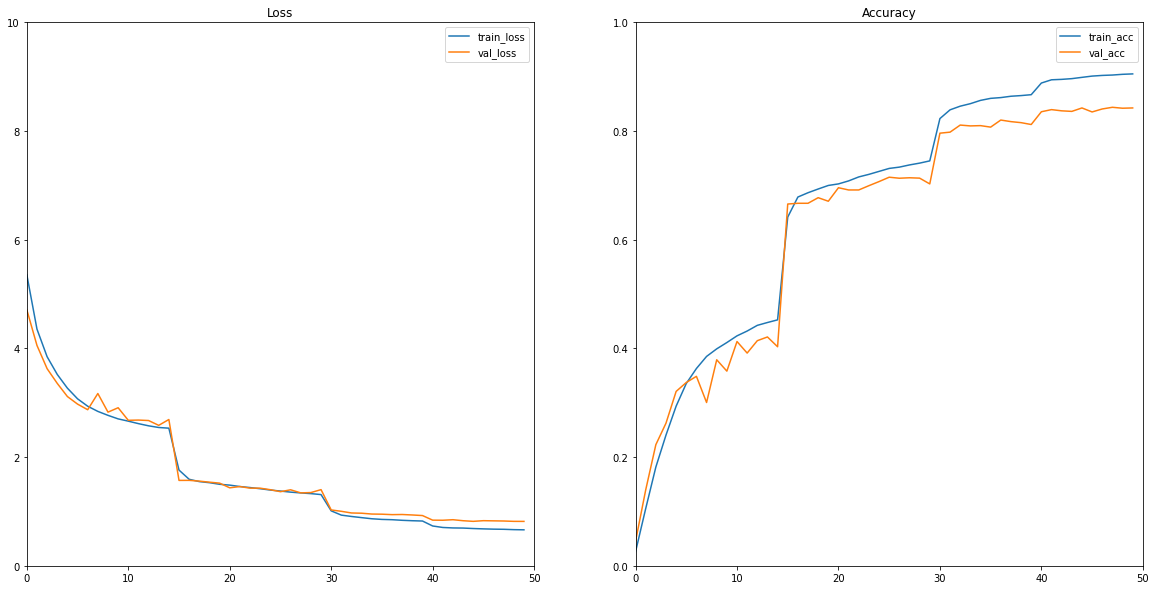

In [22]:
train_loss = loss['train']
val_loss = loss['val']
train_acc = acc['train']
val_acc = acc['val']

epochs_range = range(epochs)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.ylim(0,10)
plt.xlim(0,50)
plt.plot(epochs_range, train_loss, label='train_loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc=0)
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc ,label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.legend(loc=0)
plt.ylim(0,1)
plt.xlim(0,50)
plt.title('Accuracy')

In [24]:
seed = 0
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

torch.manual_seed(3334)
test_transform = transforms.Compose([transforms.Resize((32,32)),transforms.RandomRotation(45),transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# splitting the data into train/validation/test sets
test_data_dir = '/content/gdrive/MyDrive/competition/dataset/Bird/test'
_data = datasets.ImageFolder(test_data_dir)
test1_size = int(len(_data)*1)
test2_size = int((len(_data)-test1_size))
test_data, test2_data = torch.utils.data.random_split(_data,[test1_size, test2_size])
torch.manual_seed(3334)

print(f'test size: {len(test_data)}')

test_data.dataset.transform = test_transform
batch_size = 32
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
print(test_loader)

test size: 2000


In [26]:
import itertools
# testing how good the model is
def evaluate(model,criterion):
    model.eval()       # setting the model to evaluate mode
    preds = []
    Category = []

    test_model = WideResNet(args.depth, args.width_factor, args.dropout, in_channels=3, labels=400).to(device)
    #저장경로는 변경하셔도 됩니다.
    test_model.load_state_dict(torch.load('/content/gdrive/MyDrive/sam-main/example/model_best.pt'))

    for inputs, label_ in test_loader:
        
        inputs = inputs.to(device)
        labels = label_.to(device)
        # predicting
        with torch.no_grad():

            outputs = test_model(inputs)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)

    category = [t.cpu().numpy() for t in preds]
    
    t_category = list(itertools.chain(*category))
   
    Id = list(range(0, len(t_category)))

    prediction = {
      'Id': Id,
      'Category': t_category 
    }

    prediction_df = pd.DataFrame(prediction, columns=['Id','Category'])
    #저장경로는 변경하셔도 됩니다.
    prediction_df.to_csv('/content/gdrive/MyDrive/competition/prediction.csv', index=False)

    print('Done!!')
        
    return preds

# testing the model
predictions = evaluate(model, criterion)

Done!!
